# Introduction
*Cats* (*C*urtain *A*nalysis and *T*racking *S*oftware) is a Python library that simplifies handling and processing of single-molecule [DNA Curtains](http://www.thegreenelab.com/dnacurtains/) experiments. The goal is to accelerate, uniformize and increase the reproducibility of going from raw images to actionable plots and data.

Cats simplifies the following tasks:
- Importing and chopping images
- Aligning channels
- Drawing kymograms
- Tracking particles
- Analyzing particles

Cats revolves around core objects and principles:
1. The *Images* object
1. The *DNA* and *DNAs* objects
1. The *Kymogram* object
1. The *Particle* and *Particles* objects
1. The principle of *extensions*

We will go through all of these objects and their use to perform the tasks stated above.

First, I'll integrate plotting functions into the notebook.

In [1]:
%matplotlib notebook

# cats

### Dependencies
In order to use cats, you will need to have several python libraries installed:
- numpy
- matplotlib
- scipy
- pandas
- scikit-image (skimage)
- imageio
- PIL/Pillow
- [trackpy](https://soft-matter.github.io/trackpy/v0.3.2/)
- [pims](https://github.com/soft-matter/pims)

Most of these libraries are shipped with python distributions like [anaconda](https://www.anaconda.com/download/). The `trackpy` and `pims` can be install via `pip` or `conda`, as such

In [2]:
! pip install trackpy
! pip install pims

Note that the `!` at the beginning of each line is used in Jupyter notebooks to execute shell scripts. `pip` has to be run in the shell.

### Loading cats

Cats is a library, but it is not yet released. For now, simply add the path of the _cats_ folder to your python system path.

In [3]:
import sys
sys.path.append('/home/corentin/Code/cats/')

Replace `/home/corentin/Code/cats/` with the actual path to the folder, on your computer. This will make cats available to load as a python module

In [4]:
import cats

### Accessing documentation

Cats is fairly well documented. In jupyter or in an IPython notebook, simply add a `?` after a object/method/function name to obtain its documentation.

In [5]:
cats.Images?

One can also call the `help` function on an object, independently of the python environment, although the output is slightly less elegant.

In [6]:
help(cats.Images)

Help on class Images in module cats.images:

class Images(builtins.object)
 |  Handle multi-dimensinal images/datasets.
 |  
 |  Import is based on PIMS and, as a consequence, all formats supported are
 |  those supported by PIMS.
 |  
 |  Channels are not supported for now.
 |  
 |  The Images objects are indexable for frames and dimensions, in the order
 |  (frame, y, x). If only one frame is requested, it will return a
 |  pims.frame.Frame object. If several frames are requested, it will return an
 |  Images object sliced accordingly.
 |  
 |  Images objects can be pickled and unpickled. If they are unpickled in the
 |  absence of the source of the images, the user will, of course, not be able
 |  to access the images themselves, but will still be able to use the object.
 |  If one brings the source back, one can use the 'reload' method to reload
 |  the object with the images.
 |  
 |  Parameters:
 |  -----------
 |  images: str, pims or cats.Images object
 |      The images to rea

# Images
The `cats.Images` object provides a simple interface to handle raw data. It takes in a variety of formats and is based on the [`pims`](https://github.com/soft-matter/pims) library for importing data. As such, it supports all formats that `pims` supports. From the `pims` [documentation](http://soft-matter.github.io/pims/v0.4/):

> Formats readable by pims include:
> 
> - Directories or zipfiles of still images (most formats, including TIFF, JPEG, PNG, BMP), and TIFF stacks
> - Microscope images supported by the Bio-formats project, including Leica, Nikon, Olympus, and Zeiss formats. Requires separate installation; see below.
> - Movie formats and codecs supported by ffmpeg, including AVI, QuickTime MOV, and H.264 (MP4). May require separate installation; see below.
> - CINE files from Vision Research cameras
> - SEQ files from NorPix StreamPix software

To load images. Simply give the `cats.Images` object the path to the data. If the data is a folder of image files, you need to indicate the extension of the files. For example, for tif files, use the `*.tif` operator, as follow:

### Loading images

To load images in cats, simply instanciate a `cats.Images` object with the path to the images. If the images are in a directory, make sure to add the `*.tif` (or `*.extension`, with `extension` the type of your images) to select all image files.

In [7]:
images = cats.Images('/run/media/corentin/Cats/Corentin/DNA Curtains/171113. Condensin vs tension/02. Rotated/*.tif')

It is generally a good idea to check the data with [ImageJ/FiJi](https://fiji.sc/) prior, as well as to rotate the data so that the barriers are fully vertical.

We now have loaded the images in `cats`. One may want to look at the first frame:

Frame([[   0,    0, 1689, ...,    0,    0,    0],
       [   0,    0, 1698, ...,    0,    0,    0],
       [   0,    0, 1762, ...,  263,  263,  304],
       ...,
       [1738, 1569, 1575, ...,  270,  268,    0],
       [1760, 1416, 1459, ...,  291,  289,    0],
       [   0,    0,    0, ...,  279,  271,    0]], dtype=uint16)
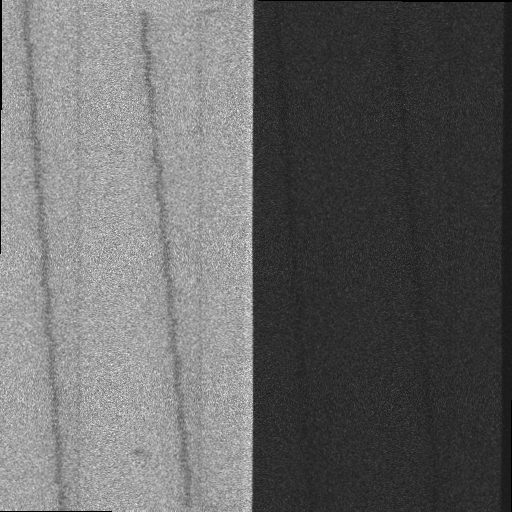

In [8]:
images[0]

As you can see, this is a white light image. I always collect more than 10 white light images at the beginning of each movie to be able to locate precisely the barriers and pedestals. This is helpfull to align channels and DNA molecules  and reduce subsequent imprecisions in the data due to poor alignment.

### Slicing images
You can also see that this is a dual-view image. The camera is split in two different channels, both showing the same field of view at different wavelengths of light. One could be interested in only looking at one of the channels. This can be easily done by slicing the image:

Frame([[   0,    0, 1689, ..., 1181,  620,  629],
       [   0,    0, 1698, ...,  903,  550,  419],
       [   0,    0, 1762, ..., 1206,  521,  428],
       ...,
       [1738, 1569, 1575, ...,  549,  431,  517],
       [1760, 1416, 1459, ...,  485,  417,  427],
       [   0,    0,    0, ...,  434,  456,  357]], dtype=uint16)
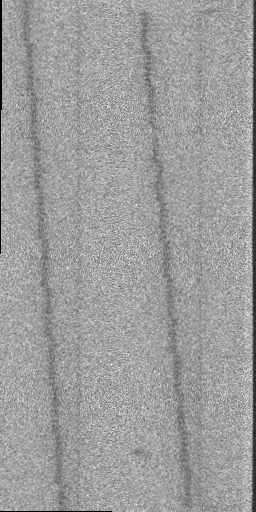

In [9]:
images[0, :, :256]

Images are sliced in the following order:
1. Frame
1. y axis
1. x axis

Above, following python's [slicing syntax](https://docs.python.org/3.6/tutorial/introduction.html#lists), we took the first frame, all of the y axis, and the x axis up to the 256th pixel (excluded). All combinations work. Most of the time, one will be interested in taking all of the images, but only a certain Region Of Interest (ROI), for example for particle tracking. Likewise, this can be done using slicing:

Frame([[ 724,  698,  796,  917,  791, 1023, 1084, 1135, 1082, 1305,  985,
         539,  832,  839,  738,  660,  815, 1243,  890, 1080, 1066, 1164,
         965,  752,  931,  982,  867, 1089,  835, 1075,  829,  942,  898,
         882, 1077, 1118,  943, 1196, 1223,  875],
       [ 668,  726,  757,  801,  779,  983,  933, 1243, 1584, 2093, 1479,
         931, 1026,  898,  599,  640,  751, 1066, 1314, 1437, 1198, 1187,
         898,  731,  760,  916,  972, 1063,  894,  950,  848,  842,  942,
         990,  804, 1161,  940, 1220, 1029,  911],
       [ 923,  762,  812,  766,  714, 1059, 1133, 1442, 2055, 2581, 2232,
        1222, 1002,  778,  721,  970,  804, 1005, 1129, 1157, 1138, 1040,
         848,  801,  710,  998,  988, 1094,  946,  910,  935,  735,  877,
        1174,  908,  905,  926,  977,  844,  831],
       [ 858,  754,  765,  817,  708, 1023, 1235, 1449, 1806, 2194, 1895,
        1171,  874,  722,  845, 1086,  972,  976,  719,  876,  920,  985,
         898, 1046,  752, 1023,  781,  996,  908,  945,  877,  858,  984,
         969,  956, 1071, 1051, 1124,  944,  960],
       [ 726,  603,  682,  861,  847,  824, 1145, 1543, 1459, 1497, 1350,
        1122,  874,  742,  897,  922,  974, 1160,  718,  936,  858,  972,
         970, 1189,  891, 1034,  758,  688,  763,  913,  967,  957,  884,
         837, 1024, 1162, 1221, 1515, 1215, 1179],
       [ 657,  636,  653,  769,  750,  967,  993, 1177, 1226, 1500, 1677,
        1404,  834,  778,  811,  790, 1132, 1285, 1098, 1101, 1114, 1095,
         976, 1140,  964, 1079,  877,  822, 1006,  868, 1025,  977, 1071,
         955,  967, 1275, 1364, 2304, 1666, 1189],
       [ 890,  676,  703,  646,  728,  827,  971,  975, 1062, 1480, 1432,
        1495,  764,  657,  710,  724, 1302, 1149, 1462, 1131, 1156, 1160,
        1325, 1345, 1311, 1337, 1360, 1093, 1121,  861, 1220, 1207, 1203,
        1073, 1109, 1560, 1599, 2337, 1956, 1345],
       [ 853,  789,  804,  576,  765,  952,  957,  910,  900, 1108, 1169,
        1032,  686,  660,  772,  703, 1082, 1190, 1439, 1008,  986, 1243,
        1521, 1643, 1568, 1393, 1428, 1155, 1100, 1008, 1262, 1378, 1024,
        1075, 1008, 1550, 1125, 1392, 1186, 1375],
       [ 667,  745,  724,  756,  789,  766,  768, 1002,  914,  896, 1238,
         858,  808,  827,  721,  675,  772, 1104, 1287, 1025,  887, 1117,
        1145, 1296, 1260, 1012, 1013, 1058, 1053, 1236,  991, 1065,  986,
         892,  933, 1162,  931, 1080, 1005, 1118],
       [ 741,  899,  946,  840,  763,  687,  808,  887,  959, 1194, 1179,
        1090, 1069,  987,  919, 1122,  839,  860, 1029, 1144, 1051,  883,
         995,  966, 1043,  897,  883,  933,  821, 1140,  902,  921,  895,
         849,  983,  938,  884, 1064, 1108, 1010]], dtype=uint16)
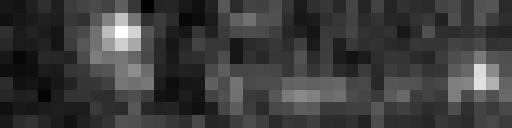

In [10]:
roi = images[32:, 120:130, 20:60]
roi[0]

Here, I took the region going from y=120 to y=130, x=20 to x=60, from frame 32 until the last one. What is shown is the first image of that ROI.

When a `cats.Images` object is sliced into a single frame, then a `pims.Frame` object is returned. When it is sliced into several frames, then a `cats.Images` object is returned.

### Iterating over frames

Finally, the `Images` object is iterable. It can be used in while/for loops and other functions to walk over the data:

In [11]:
max_values = [np.max(image) for image in images[:10]]
max(max_values)

37179

### Images are not stored in memory

Unlike in ImageJ, `Images` objects dot not store frames in memory (except maybe for nd2 files and other "one file, several images" formats), but reads them one by one from the disk. This is because images are usually only read once, for tracking, and do not need to bloat the memory. Hence, when working directly with images, it is generally advised to do all of the operations for each image before going to the other one, in order to save time by only opening images once.

In [12]:
%%timeit
max([np.max(image) for image in images[:100]]) + min([np.min(image) for image in images[:100]])

369 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
max_values, min_values = list(), list()
for image in images[:100]:
    max_values.append(np.max(image))
    min_values.append(np.min(image))
max(max_values) + min(min_values)

228 ms ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As can be seen above, it is more than 1.5X faster to open images just once instead of twice.

### Advanced indexing

`Images` objects support [advanced, numpy-like indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#advanced-indexing). For example, let's use the drawing function of scikit to get a linear section of the image.

In [14]:
import skimage.draw
line = skimage.draw.line(329, 12, 277, 12)
line

(array([329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317,
        316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304,
        303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291,
        290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278,
        277]),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12]))

In [15]:
sliced_images = images[32:, line[0], line[1]]
sliced_images.shape

(2069, 53)

The current limitation is that the frame indexing and the pixel indexing must be separated. One cannot, for example, use a 3-dimensional boolean array to select pixels across frames. One annoyance steming from this limitation is that, as shown above, 2D tuples for pixels must be unpacked manually.

Here, I'll shorten the dataset to save myself some computation time for the examples.

In [16]:
images = images[500:900]

# 3. DNA molecules
In DNA Curtains, the substrate for data is DNA. All of the data is located on DNA molecules, sometimes across different channels, sometimes using only one channel. The `DNA` object simplifies the management and alignment of several channels, as well as building kymograms, ROIs and tracking particles.

There are two types of DNA objects:
1. The `DNA` object, which supports multiple channels, each channel being a `DNAChannel` object
1. The `DNAChannel` object, which supports only one channel

### Instanciation of a DNA object
To instanciate a DNA object, one needs to define its location across channels and the images it resides in. Below, `'DNA'` is the name of the channel, and `beginning` and `end` are the positions of the first (barrier) and last (pedestal) pixels of the molecule.

In [17]:
beginning =  (79,   7)
end =  (27,   7)
dna = cats.DNA('DNA', images, beginning, end)
dna

{'DNA': DNA channel starting at (79, 7) and ending at (27, 7) in  <cats.images.Images object at 0x7fc3e06bac50>}

One can add channels to the DNA molecule

In [18]:
dna.add_channel('Condensin', images, (329,   12), (277,   12))
dna

{'Condensin': DNA channel starting at (329, 12) and ending at (277, 12) in  <cats.images.Images object at 0x7fc3e06bac50>,
 'DNA': DNA channel starting at (79, 7) and ending at (27, 7) in  <cats.images.Images object at 0x7fc3e06bac50>}

One can also directly instanciate the object with several channels.

In [19]:
dna = cats.DNA(DNA=(images, beginning, end), Condensin=(images, (329,   12), (277,   12)))
dna

{'Condensin': DNA channel starting at (329, 12) and ending at (277, 12) in  <cats.images.Images object at 0x7fc3e06bac50>,
 'DNA': DNA channel starting at (79, 7) and ending at (27, 7) in  <cats.images.Images object at 0x7fc3e06bac50>}

Note that there is no limit to the number of channels one can add.

#### Single-channel datasets

If there's only one channel to the dataset, one can skip the name. An unnamed single channel DNA molecule will be instanciated as a DNAChannel object.

In [20]:
dna = cats.DNA(images, beginning, end)

In [21]:
type(dna)

cats.dna.DNAChannel

 A `DNAChannel` object can be made multichannel with the `as_multichannel` method, giving it the name of the channel for parameter

In [22]:
type(dna.as_multichannel('DNA'))

cats.dna.DNA

In [23]:
dna = dna.as_multichannel('DNA')
dna.add_channel('Condensin', images, (329,   12), (277,   12))

All methods and attributes in `DNA` are available in `DNAChannel`, except the ones that require multiple channels.

### Using DNA objects

#### Accessing channels

There is two ways to access channels in a DNA object: as dictionnary items and as attributes.

In [24]:
dna['DNA']

DNA channel starting at (79, 7) and ending at (27, 7) in  <cats.images.Images object at 0x7fc3e06bac50>

In [25]:
dna.DNA

DNA channel starting at (79, 7) and ending at (27, 7) in  <cats.images.Images object at 0x7fc3e06bac50>

In addition, one can access the channel names via the `channel_names` attribute

In [26]:
dna.channel_names

('DNA', 'Condensin')

and the channels, in the form of the pair (name, channel) via the `channels` attribute

In [27]:
for name, channel in dna.channels:
    print(name, channel.beginning)

DNA (79, 7)
Condensin (329, 12)


#### Methods and attributes
Methods and attributes can be applied to channels individually or globally. A method executed by the `DNA` object will be executed on both channels, and will return the output as a `dict` in the form `channel_name: result`.

In [28]:
dna.roi

{'Condensin': <cats.images.Images at 0x7fc3e06c2eb8>,
 'DNA': <cats.images.Images at 0x7fc3e06c2748>}

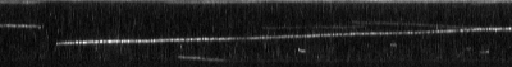

In [29]:
dna['Condensin'].kymogram

`DNA` and `DNAChannel` objects provide methods for drawing and tracking data:
- `roi` will return a subset of the images centered around the DNA molecule
- `kymogram` will return a `Kymogram` object of the DNA molecule (see Kymogram section below)
- `length` will return the length, in pixels, of the DNA molecule
- `track()` will track content in the `roi` of the DNA molecule (see Tracking section below)
- `draw_particles()` will color the detected particles onto the kymogram for visual inspection
- `merge_kymograms()` will create a composite image of the kymogram of the given channels

You can check the help page of each method for more information.

### Collections of DNA molecules

Most often, we work with several DNA molecules. To ease importing and working with several DNA molecules, one can use the `DNAs` object, which is simply a list of DNA molecules.

`DNAs` object can be instanciated with a list of `DNA`/`DNAChannel` objects, or from CSV file of the coordinates.

In [30]:
dnas = cats.DNAs.from_csv('/home/corentin/PhD/Projects/08. Condensin/Condensin vs tension/Data/171113.02/DNA molecules.csv', images, 'DNA', invert_coordinates=True)

In [31]:
help(cats.DNAs.from_csv)

Help on function from_csv in module cats.dna:

from_csv(f, images, name=None, invert_coordinates=False)
    Import DNA molecules from CSV files.
    
    Transform a CSV lines list from ImageJ into a list of dna coordinates.
    
    Parameters:
    ----------
    f: str
        the CSV file
    images: cats.images.Images
        the images in which the DNA molecules are recorded
    name: str
        the name of the channel in the CSV file. If None, will create single-channel objects.
    invert_coordinates: bool
        whether to invert the coordinates in the file, so that the top of the kymogram becomes the bottom. Useful if your images have pedestals at the left and barriers at the right.
    
    How to use:
    -----------
    - Draw a line over the DNA
    - Measure it (Ctrl+M)
    - Make sure you have the following measurements set:
        - Boundary rectangle
    - Save with the column headers on.



In [32]:
len(dnas)

70

We just imported 70 DNA molecules, previously deliminated in ImageJ.

`DNAs` objects support all the methods and attributes from `DNA` and `DNAChannel` object, and will output their result as a list, with the output of the first `DNA` object being the first output of the returned list.

In [33]:
dnas.length

[53,
 53,
 53,
 53,
 45,
 46,
 42,
 42,
 42,
 42,
 39,
 35,
 28,
 27,
 24,
 20,
 20,
 57,
 57,
 57,
 54,
 52,
 54,
 54,
 54,
 54,
 53,
 48,
 50,
 50,
 50,
 46,
 46,
 46,
 46,
 40,
 42,
 42,
 41,
 42,
 37,
 38,
 38,
 35,
 35,
 35,
 35,
 35,
 35,
 29,
 29,
 29,
 29,
 27,
 27,
 27,
 27,
 27,
 22,
 22,
 22,
 22,
 22,
 19,
 19,
 19,
 21,
 17,
 17,
 14]

<IPython.core.display.Javascript object>


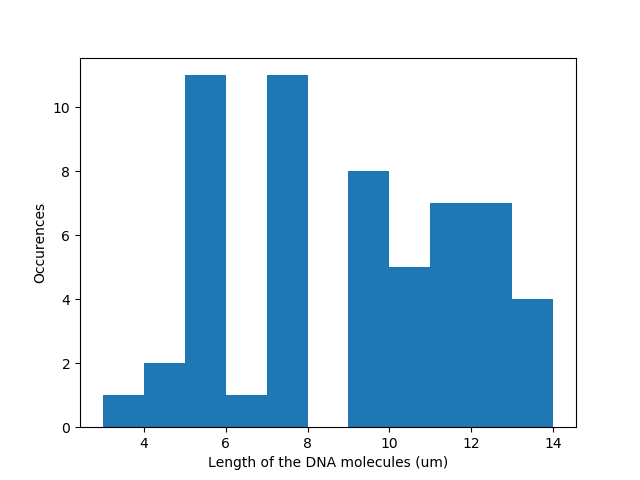

Text(0.5,0,'Length of the DNA molecules (um)')

In [34]:
plt.figure()
plt.hist(np.array(dnas.length) * (16 / 60), bins=np.arange(3,15))
plt.ylabel('Occurences')
plt.xlabel('Length of the DNA molecules (um)')

As can be seen from the histogram, DNA lengths from 3 to 15 um are populated very unevenly, and to get a comprehensive dataset of what happens at different DNA lengths, many more flowcells will be necessary!

#### Aligning channels

It's also possible to mass-add channels to our DNA molecules. A common case is that we have two channels in our dataset, these channels are not aligned, and we want to know what happens on the DNA molecule in both channels. Cats will help you with that.

First, you will need a reference point that you know to be the same in both channels. I use the top corner of the first barrier in the dataset. This is easy to align precisely, as it forms a right angle that can be drawn with a box in ImageJ.

Second, you need to generate a registration function that will calculate the translation between the two datasets and will generate the coordinates in the second dataset based on those of any point in the first dataset. The `cats.dna.generate_registration_function` will generate that function for you, based on the coordinates obtained above.

In [35]:
reg_func = cats.dna.generate_registration_function((200, 12), (450, 17))
reg_func(0, 0)

(250, 5)

The origin of the second channel is 250px right and 5pixels down! (In images, the origin is at the top left, so +5px means moving down 5px)

Third, we can use that registration function to automatically generate the second channel for all DNA molecules using `DNAs.register_channel`.

In [36]:
dnas.register_channel('Condensin', images, reg_func, 'DNA')

Here, we create a channel `'Condensin'` from the images `images` using the registration function `reg_func` and the coordinates of the channel `'DNA'` as a reference. Note that if your DNA molecules only have one channel, the reference will be inferred, so you do not need to write it.

In [37]:
dnas[0]

{'Condensin': DNA channel starting at (329, 12) and ending at (277, 12) in  <cats.images.Images object at 0x7fc3e06bac50>,
 'DNA': DNA channel starting at (79, 7) and ending at (27, 7) in  <cats.images.Images object at 0x7fc3e06bac50>}

<IPython.core.display.Javascript object>


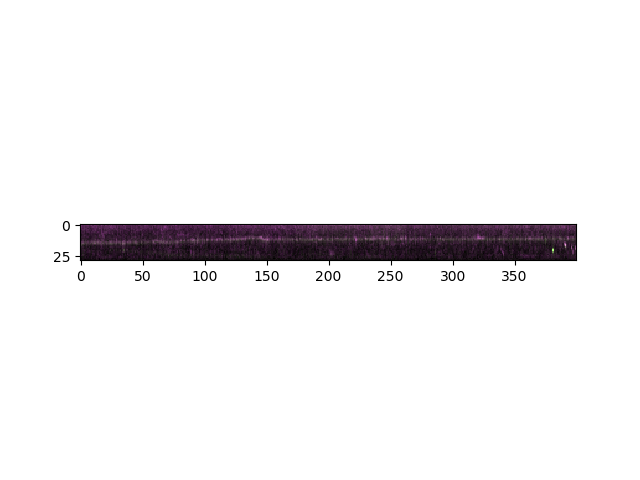

In [38]:
plt.figure()
plt.imshow(dnas[49].merge_kymograms())

Here we are, two perfectly aligned channels for 70 DNA molecules based on just one measurement!

#### Selecting by channel
In addition, one can access only one channel for all DNA molecules in the object using the usual 'dict-like' indexing.

In [39]:
dnas['DNA'][:10].beginning

[(79, 7),
 (79, 11),
 (79, 18),
 (79, 29),
 (79, 122),
 (79, 127),
 (79, 149),
 (80, 169),
 (80, 175),
 (80, 181)]

#### Generating kymograms
As said before, you usually only want to open images once, as opening images takes time. To save time generating kymograms, the `DNAs` object has a `generate_kymograms` method. It will generate kymograms in all channels for all DNA molecules, only reading the images once, hence saving time.

In [40]:
dnas.generate_kymograms()

#### Methods and attributes
`DNAs` objects possess all the methods and attributes of the `DNA` and `DNAChannel` objects, as stated before. They also implement a few more methods that the ones presented above:
- `add_channel` to add a channel to every DNA molecule in the list, based on a list of coordinates
- `save_kymograms` to save all of the kymograms from all of the DNA molecules in the given folder
- `draw_particles`, which unlike `DNA.draw_particles`, will not output a file, but save the image in the given folder.

#### Tracking particles
The `DNAs` object provides the convenience function `track`. See the 'Tracking' section of this manual to see how to use it.

#### Saving the work
Finally, after all of this hard work, aligning channels, tracking particles, generating kymograms, one may want to save the progress. This can be done using the `save` method in all `DNAs`, `DNA` and `DNAChannel` objects. For example

In [41]:
dnas.save('/home/corentin/PhD/Projects/08. Condensin/Condensin vs tension/Data/171113.02/DNA molecules.pckl')

The file can easily be retrieved using the `load` method:

In [42]:
dnas = cats.DNAs.load('/home/corentin/PhD/Projects/08. Condensin/Condensin vs tension/Data/171113.02/DNA molecules.pckl')

In [43]:
len(dnas)

70

## Kymograms

Kymograms are the bread and butter of the DNA Curtains industry, and Cats implements it as the `Kymogram` object.

Kymograms can be instanciated using point coordinates and a set of images:

In [44]:
reload(cats.kymograms)
reload(cats)

<module 'cats' from '/home/corentin/Code/cats/cats/__init__.py'>

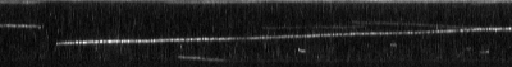

In [45]:
kymo = cats.Kymogram.from_coordinates((329,   12), (277,   12), images)
kymo

They can also be directly imported from a slice of pixels

In [46]:
kymo = cats.Kymogram.from_slice((np.array(12), np.arange(329, 277, -1)), images)

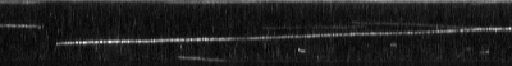

In [47]:
kymo

`Kymogram` objects are numpy arrays and are compatible with all associated functions.

<IPython.core.display.Javascript object>


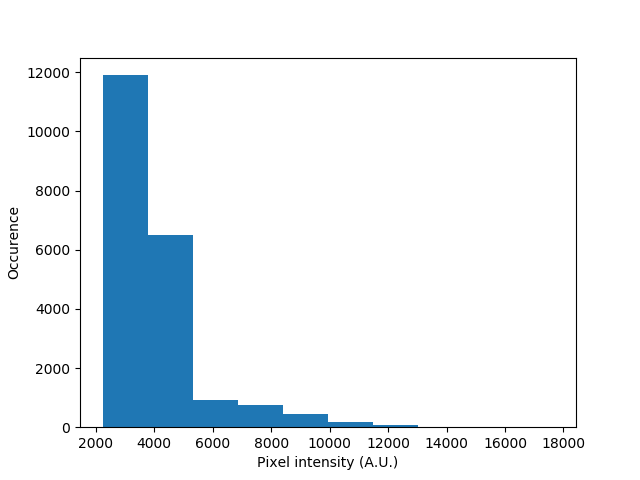

In [48]:
plt.figure()
plt.hist(kymo.flatten())
plt.xlabel('Pixel intensity (A.U.)')
o = plt.ylabel('Occurence')


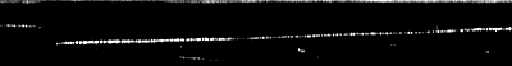

In [49]:
import skimage.exposure
skimage.exposure.rescale_intensity(kymo, (6000, 11000)).view(cats.Kymogram)

Because it is treated as a numpy array, very often, functions will return a numpy array instead of a Kymogram object. If you wish to retain some features, use the `.view(cats.Kymogram)` function on the returned array to convert it to a kymogram object with, for example, automatic image output in Jupyter Notebooks :)

One can also export the kymogram as a RGB image

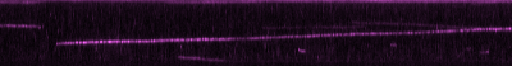

In [50]:
kymo.as_rgb(cats.colors.scheme[1])

Note that I use a color from the `colors` module here. Any color format that's recognized by `matplotlib` would work. From the [matplotlib doc](https://matplotlib.org/api/colors_api.html):
> Matplotlib recognizes the following formats to specify a color:
>
>    - an RGB or RGBA tuple of float values in [0, 1] (e.g., (0.1, 0.2, 0.5) or (0.1, 0.2, 0.5, 0.3));
>    - a hex RGB or RGBA string (e.g., '#0F0F0F' or '#0F0F0F0F');
>    - a string representation of a float value in [0, 1] inclusive for gray level (e.g., '0.5');
>    - one of {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};
>    - a X11/CSS4 color name;
>    - a name from the xkcd color survey; prefixed with 'xkcd:' (e.g., 'xkcd:sky blue');
>    one of {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'} which are the Tableau Colors from the ‘T10’ categorical palette (which is the default color cycle);
>    - a “CN” color spec, i.e. 'C' followed by a single digit, which is an index into the default property cycle (matplotlib.rcParams['axes.prop_cycle']); the indexing occurs at artist creation time and defaults to black if the cycle does not include color.


Kymograms can also be sliced as one would do with an array

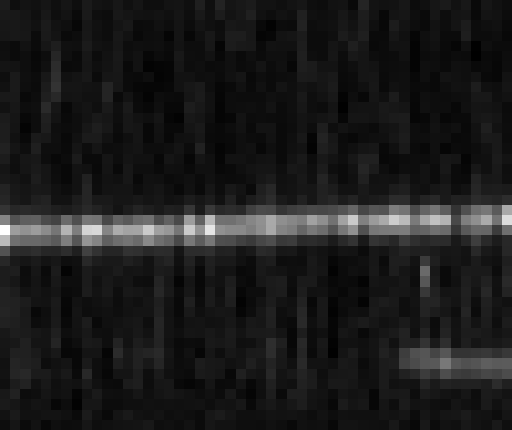

In [51]:
subset = kymo[10:, 100:150]
subset

If the display size is too large or too small, one can change the `display_width` attribute from its default value of `512`.

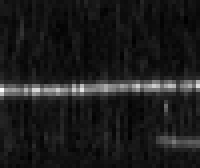

In [52]:
subset.display_width = 200
subset

To save a kymogram, simply use the `save` method.

In [53]:
kymo.save('kymo.tif')

Note that this also work with RGB'd kymograms

In [54]:
kymo.as_rgb(cats.colors.scheme[1]).save('rgb_kymo.png')

## Tracking

One of the main goals of cats is to make tracking of particles fast and reproducible. However, tracking is hard, and our brains and eyes are especially good at it. There's three main components to tracking.
1. _Detection_ of the signal from the background
2. _Filtering_ of the signal from the noise
3. _Identification_ of the signal coming from a same source

`cats` will split these components into two appropriately named submodules: 
1. The `detect` submodule
2. The `filter` submodule

The signal detected is called a `feature`. It's a usually circular spot existing at one position from one image. A `particle` will be several `feature`s (one per image at most) assembled into a list because they have been identified as being the same object across images.

As such, `cats` splits the tracking work as follow:
- Detect features using `cats.detect.features`
- Filter features using `cats.filter.features`
- Assemble particles from features using `cats.detect.particles`
- Filter particles using `cats.filter.particles`

For now, the detection work is done by the [`trackpy` library](https://soft-matter.github.io/trackpy/v0.3.2/), which works well. The curious can go read their excellent [walkthrough](https://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html) to get a better understanding of the parameters using for tracking, as `cats` does not alter them.

Also note that`cats` is built as such that one could add their own detection and filtering library.

### Tracking from images
Let's track particles from images, to demonstrate the functioning. We'll use the region of interest of one of our DNA molecules.

Frame([[4385, 4593, 4731, 4412, 3990, 3834, 3977, 3717, 3482, 3467, 3202,
        3475, 3576, 3389, 3559, 4091, 4238, 3711, 3631, 3331, 3670, 4022,
        3630, 3324, 3015, 2849, 3364, 3234, 3506, 3837, 3692, 3297, 2937,
        2958, 3371, 3141, 3287, 3550, 3401, 3441, 2911, 2576, 2672, 2841,
        3189, 3136, 3067, 3044, 3015, 2985, 2951, 3289],
       [5852, 6733, 6410, 4639, 3942, 3988, 4355, 4536, 3721, 3333, 3309,
        3482, 3619, 3599, 3556, 3450, 3323, 3138, 3600, 4183, 5028, 4435,
        3605, 3148, 3025, 2728, 2840, 2904, 3563, 3422, 3228, 3292, 2948,
        2791, 3298, 3010, 3364, 3828, 3487, 3115, 3061, 3084, 2803, 3042,
        3384, 3599, 3130, 2843, 2805, 2987, 2996, 3200],
       [7752, 9525, 7868, 5113, 4200, 4338, 4491, 4832, 3866, 3210, 3218,
        3291, 3526, 3525, 3820, 3909, 3375, 3446, 4184, 6706, 7474, 5259,
        3381, 2746, 2875, 2915, 2908, 3467, 3743, 3671, 3338, 3150, 3249,
        2898, 3166, 3197, 3378, 3342, 3401, 3042, 3228, 3400, 3058, 3038,
        3277, 3341, 3171, 3201, 2897, 3404, 3520, 3291],
       [7349, 7801, 6093, 5004, 4351, 4157, 3970, 4008, 3564, 3283, 3364,
        3273, 3224, 3426, 3772, 3831, 3525, 3533, 4113, 6643, 7197, 5017,
        3112, 2586, 2970, 2854, 2757, 3259, 3381, 3842, 3662, 3650, 3666,
        3757, 3402, 3170, 2968, 2835, 3228, 3290, 3350, 3512, 3247, 3014,
        3331, 3462, 3417, 3866, 3682, 3156, 3031, 2962],
       [5705, 4819, 4525, 4719, 4080, 3622, 3459, 3815, 3627, 3936, 4552,
        4055, 3314, 3565, 3591, 3182, 3342, 3897, 3742, 4692, 4712, 4169,
        3588, 2916, 2867, 3022, 3224, 4200, 3555, 3435, 3689, 3694, 3770,
        3956, 3278, 3055, 2948, 2874, 2895, 3130, 3588, 3649, 3625, 3217,
        3726, 4029, 3936, 3827, 3537, 3210, 2976, 2922],
       [4821, 4290, 4253, 4360, 3774, 3603, 3652, 3946, 3912, 4197, 4834,
        4420, 3789, 3640, 3498, 3130, 3734, 4205, 3619, 3418, 3227, 3401,
        3517, 3494, 3402, 3384, 4158, 4808, 4488, 3817, 3139, 3586, 3646,
        3673, 3599, 3318, 3135, 2810, 3057, 3292, 3397, 3399, 3161, 3053,
        3492, 4154, 4076, 3488, 3138, 2974, 2614, 2868]], dtype=uint16)
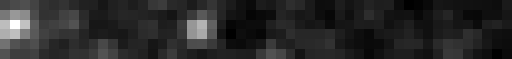

In [55]:
roi = dnas[0]['Condensin'].roi
roi[0]

The eye clearly sees at least 2 features in this image, and maybe even 3, if we only consider the ones not on the edges. Let's see what `cats` see!

In [56]:
cats.detect.features(roi[0])

Frame 0: 5 features


,x,mass,size,ecc,signal,raw_mass,ep,frame
0,2.303482,292.961105,0.550892,NaN,204.052687,13736.0,0.138351,0
1,15.780779,554.747740,0.690137,NaN,290.527262,12040.0,0.232508,0
2,21.316291,504.040461,0.718845,NaN,243.583795,11322.0,0.326608,0
3,29.173773,590.772163,0.765294,NaN,244.771900,11035.0,0.389643,0
4,38.042723,480.757140,0.731925,NaN,223.208672,10392.0,0.686472,0
5,1.621935,821.573562,0.614870,NaN,510.965252,17782.0,0.046977,0
6,6.687991,506.020552,0.623576,NaN,309.256243,12612.0,0.118695,0
7,20.094772,1353.080568,0.729550,NaN,632.911995,13646.0,0.090931,0
8,37.091511,523.346319,0.741551,NaN,235.558960,10679.0,0.276549,0
9,44.759885,504.851980,0.682920,NaN,269.399254,10113.0,0.452924,0


27 features! Clearly, one of us is wrong, and clearly, that's `cats`. The thing is, our eyes naturally filter a lot. We only consider the strongest particles and dismiss the rest as noise. If you really look into the image, though, you'll see lots of background, less intense particles, that most likely aren't bound to the DNA molecule, but `cats` don't know that! We'll have to proceed to some filtering.

`trackpy` calls the total brightness of a feature `mass`. When looking at the mass of particles, you can see that 2 of them are above 3000, 4 of them between 1000 and 3000, and the rest below 1000. Basically, our eyes only considered the ones above 3000! We can use the `minmass` parameter to tell the detection function to ignore anything below that value.

In [57]:
cats.detect.features(roi[0], minmass=3000)

Frame 0: 0 features


,x,mass,size,ecc,signal,raw_mass,ep,frame
0,19.833136,3343.733979,0.727999,NaN,1571.613245,19439.0,0.054347,0
1,19.798518,3162.916978,0.722762,NaN,1510.656892,18857.0,0.069050,0


That's it, good job cats! Only two features, we agree :)

Now, let's do this for all images

In [58]:
features = cats.detect.features(roi, minmass=3000)

Frame 399: 1 features


In [59]:
len(features)

515

<IPython.core.display.Javascript object>


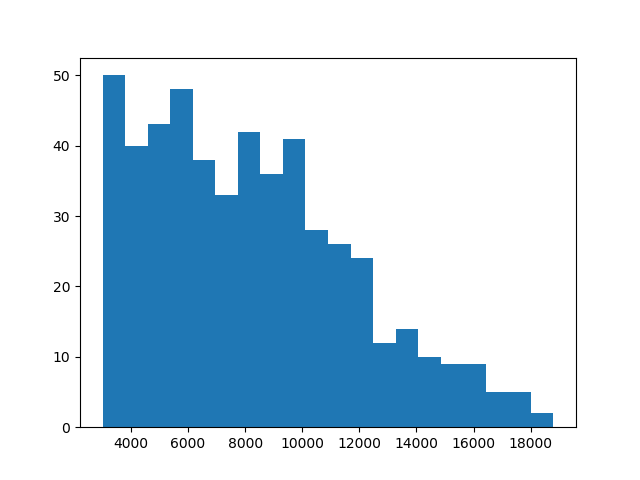

(array([50., 40., 43., 48., 38., 33., 42., 36., 41., 28., 26., 24., 12.,
        14., 10.,  9.,  9.,  5.,  5.,  2.]),
 array([ 3006.71177164,  3796.39067706,  4586.06958248,  5375.74848791,
         6165.42739333,  6955.10629875,  7744.78520417,  8534.46410959,
         9324.14301501, 10113.82192043, 10903.50082585, 11693.17973127,
        12482.85863669, 13272.53754211, 14062.21644753, 14851.89535296,
        15641.57425838, 16431.2531638 , 17220.93206922, 18010.61097464,
        18800.28988006]),
 <a list of 20 Patch objects>)

In [60]:
plt.figure()
plt.hist(features.mass, bins=20)

It roughly looks like most of our features have a mass in between 3000 and 12000, with centers around 6000 and 9000. Let's paint them red on a kymogram.

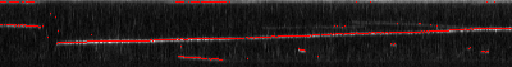

In [61]:
kymo = dnas[0]['Condensin'].kymogram.as_rgb()  # This is the molecule we took the ROI from. See, DNA objects are handy :)
kymo[features.x.values.astype(int), features.frame] = (255, 0, 0)
kymo

Good job, cats! Most of our signal is here, and there's very little noise. Maybe the minmass of 3000 was a bit too stringent, as signal is missing here. Let's do 1500.

Frame 399: 1 features


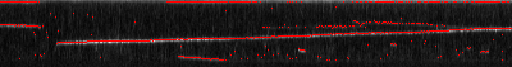

In [62]:
features = cats.detect.features(roi, minmass=1500)
kymo = dnas[0]['Condensin'].kymogram.as_rgb()
kymo[features.x.values.astype(int), features.frame] = (255, 0, 0)
kymo

We're now encompassing all of the signal I can see, but there's an issue: The noise is also higher! That's the tradeoff. Thankfully, we can deal with that in the subsequent steps.

I don't want the signal that's too close to the top and bottom of the molecule, where the barriers and pedestals are, because that's just noise 99% of the time. In addition, I know that all the signal should be fairly centered, vertically, in the region of interest, because this region of interest is centered on my DNA molecule. Finally, I estimate that features with a mass above 25000 are probably aggregates, and I want to remove that too.

In [63]:
len(features)

782

In [64]:
filtered_features = cats.filter.features(features, maxmass=25000, min_dist_from_edges=5, max_dist_from_center=2)
len(filtered_features)

581

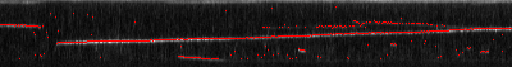

In [65]:
kymo = dnas[0]['Condensin'].kymogram.as_rgb()
kymo[filtered_features.x.values.astype(int), filtered_features.frame] = (255, 0, 0)
kymo

That's slightly cleaner, but we mostly just removed the signal on the top (barrier).

Now, let's proceed to identificating particles. Your eyes are probably doing it right now. Each of these lines is obviously one particle. cats don't know that yet, but they can do that work.

In [66]:
particles = cats.detect.particles(filtered_features)
particles.number

Frame 399: 1 trajectories present


52

Ok, now cats found 52 different particles where I maybe see 4. Clearly, we'll need some cleanup!

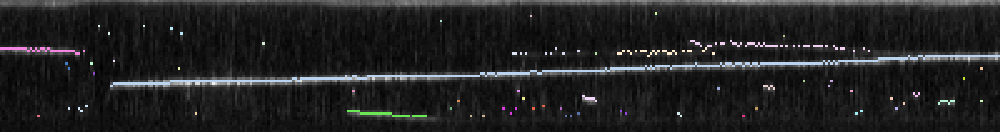

In [67]:
kymo = dnas[0]['Condensin'].kymogram.as_rgb()
for particle in particles:
    color = cats.colors.random()
    kymo[particle.x.values.astype(int), particle.frame] = color
kymo.display_width = 1000
kymo

Each color is a different particle. It did a great job finding my 4-5 main ones, but the rest is all noise! Let's get rid of it. First, a real particle is made of more than 10 features. Second, it has more that 2 features per 3 frames.

In [68]:
filtered_particles = cats.filter.particles(particles, min_features=10, min_frame_ratio=2/3)
filtered_particles.number

5

That's more like it! Let's paint these too.

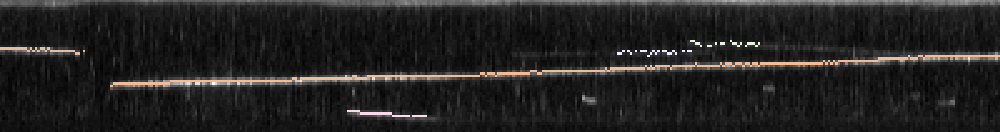

In [69]:
kymo = dnas[0]['Condensin'].kymogram.as_rgb()
for particle in filtered_particles:
    color = cats.colors.random()
    kymo[particle.x.values.astype(int), particle.frame] = color
kymo.display_width = 1000
kymo

That is almost perfect. It seems to have chopped the 2 flimsier particles at the top. That's because these regions had a density lower that 2 features per 3 frames, so cats considered that they were noise wrongfully associated with the particles. Well, cats are not perfect! We can try to lower that limit.

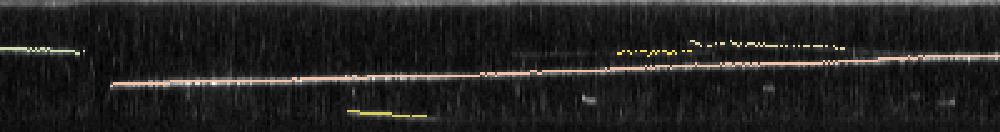

In [70]:
filtered_particles = cats.filter.particles(particles, min_features=10, min_frame_ratio=0.5)
kymo = dnas[0]['Condensin'].kymogram.as_rgb()
for particle in filtered_particles:
    color = cats.colors.random()
    kymo[particle.x.values.astype(int), particle.frame] = color
kymo.display_width = 1000
kymo

That's slightly better. To gain back the first and last half of these tracks, we'd probably have to decrease the minmass ratio we used while detecting features.

### Tracking from DNA molecules
Now that we see how tracking works, let's do it the easy way. Instead of taking our ROI and kymogram outside of our `DNA` object, let's just bring the tracking function in there.

`DNAs`, `DNA` and `DNAChannel` objects use the `track` method to simplify tracking. This method executes tracking in exactly the same order as we did above, but packs everything into one method for convenience. This is good once your filtering and tracking parameters are established. Before that, the manual method may be more efficient and help you better understand the parameters needed.

Frame 399: 1 trajectories present


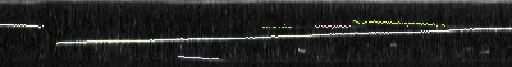

In [71]:
dnas[0]['Condensin'].track(minmass=1000, maxmass=25000, min_dist_from_edges=5, max_dist_from_center=2, min_features=10, min_frame_ratio=0.5)
dnas[0]['Condensin'].draw_particles()

Tadam! That was easy. Also, decreasing the minmass helped, but now it split that first track above into two. That's because the `memory` - the maximum number of consecutive frames without a feature in a particle - is too small. Let's try to put it at 15. Note that we did not define this before. That's a parameter of `cats.detect.particles` and its default value is 5. Don't forget to look at the doc of these functions!

Frame 399: 1 trajectories present


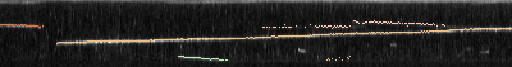

In [72]:
dnas[0]['Condensin'].track(memory=15, minmass=1000, maxmass=25000, min_dist_from_edges=3, max_dist_from_center=2, min_features=10, min_frame_ratio=0.5)
dnas[0]['Condensin'].draw_particles()

That's good, but now it merged these two top molecules! Oh well, as I said, cats are not perfect... Visual verification of the data is always a good idea, especially when mass-tracking.

In [73]:
dnas[:2]['Condensin'].track(memory=15, minmass=1000, maxmass=25000, min_dist_from_edges=3, max_dist_from_center=2, min_features=10, min_frame_ratio=0.5)
dnas[:2]['DNA'].track(memory=15, minmass=400, maxmass=25000, min_dist_from_edges=3, max_dist_from_center=2, min_features=10, min_frame_ratio=0.5)
dnas[:2].draw_particles('/home/corentin/tracked particles/')

Frame 399: 1 trajectories present


Note that I separated the tracking for the two channels, because their parameters are different. Also note that the `DNAs` method `draw_particles` writes directly to files instead of returning `Kymogram` objects.

## Particles

Tracking outputs these big tables of features, as we've seen above. When tracking with the DNA objects, these tables are stored as a `particles` attribute. 

In [74]:
dnas[0]['Condensin'].particles

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,19.946962,2.164698,5691.585335,0.853282,0.379498,1547.600563,31664.0,0.048503,0,0.0
1,19.982176,2.876658,4642.266098,0.851742,0.397497,1274.470947,30079.0,0.054265,1,0.0
2,19.969889,2.876119,2671.620861,0.853393,0.552245,725.931753,24436.0,0.067144,2,0.0
3,19.916368,2.833743,5423.061899,0.857191,0.396606,1438.326305,29088.0,0.050194,3,0.0
4,19.844837,2.819702,2750.544100,0.846370,0.528496,780.213240,26219.0,0.078142,4,0.0
5,19.882762,2.863782,6233.427533,0.853130,0.426899,1696.547279,32225.0,0.036937,5,0.0
6,19.947135,2.846583,9359.890407,0.859947,0.371197,2438.172913,40516.0,0.022369,6,0.0
7,19.904459,2.074011,9003.759818,0.856370,0.401295,2400.682698,40464.0,0.028643,7,0.0
8,19.931038,2.051362,9273.212981,0.856268,0.415763,2474.147950,40085.0,0.031626,8,0.0
9,19.929747,2.104659,8491.264324,0.853354,0.387780,2307.808779,40610.0,0.033692,9,0.0


This is the clean data: a numerical version of the images that encompasses most of the information you'd be interested in: precise location (`x`, `y`) and uncertainty on the location (`ep`), frames (`frame`), overall brightness (`mass`), signal, eccentricity of the signal (`ecc`), diameter (`size`) and identification (`particle`). This table is actually a `Particles` object, which contain `Particle` objects. All of these are based on `pandas.DataFrame` and conserve all of its properties.

`Particles` objects can be iterated over to get single `Particle` objects.

In [75]:
velocities = list()
for particle in dnas[0]['Condensin'].particles:
    velocities.extend(abs(np.diff(particle['x'] * 16 / 60) / np.diff(particle['frame'])))

<IPython.core.display.Javascript object>


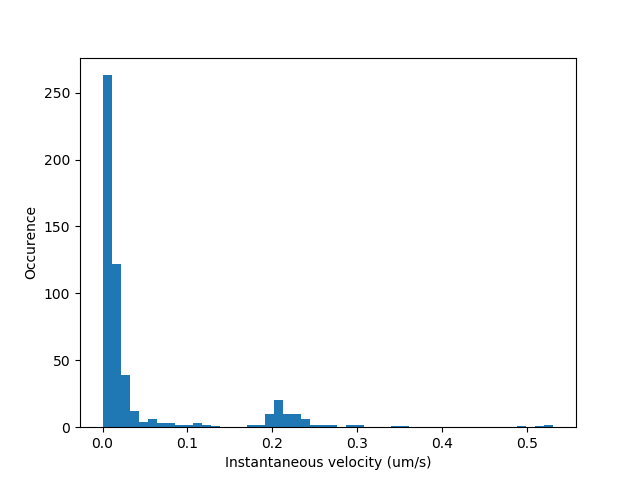

In [76]:
plt.figure()
plt.hist(velocities, bins=50)
plt.xlabel('Instantaneous velocity (um/s)')
y = plt.ylabel('Occurence')

In [77]:
filtered_particles = cats.filter.particles(particles, min_features=10, min_frame_ratio=2/3)
filtered_particles.number

5

That's more like it! Let's paint these too.

As can be seen, condensins spend most of their time doing nothing or very little!

For now, `Particle` and `Particles` object have very little methods attached to them, although this is where the meat of the analysis will happen. As I'm populating these objects, you can already design your own methods using extensions.

## Extensions

Every single cats object can be extended with user-defined functions. This makes it easy to add your own analysis functions to `Particles` or `DNAs`, for example, or even image processing functions to `Images` so that you rely less on ImageJ.

To see if an object can receive extension, simply check if it has the `accepts_extensions` method.

In [78]:
hasattr(cats.DNAs, 'accepts_extensions')

True

Great, we can extend `cats.DNAs`' functions!

Extensions are stored in the extensions directory. Each extension is saved in a file that is automatically loaded onto the objects when they are initialized. See the `cats.extensions` doc for more info!

In [79]:
cats.extensions?